# Programming Exercise 5:  Neural Networks with PyTorch

In [1]:
import os
import numpy as np
from scipy.io import loadmat
import torch
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm

import utils
%matplotlib inline

## Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

We start the exercise by first loading the dataset. 

In [2]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### 1.1 Visualizing the data

You will begin by visualizing a subset of the training set, using the function `displayData`, which is the same function we used in Exercise 3. It is provided in the `utils.py` file for this assignment as well. The dataset is also the same one you used in the previous exercise.

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
The following cell randomly selects 100 images from the dataset and plots them.

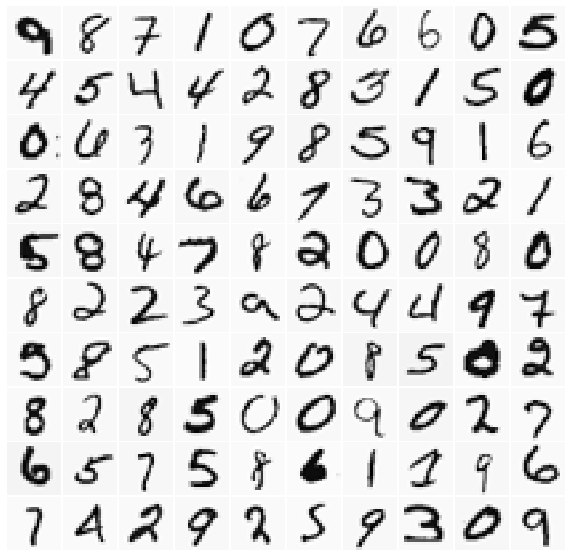

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.2 Model representation

Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [4]:
# Setup the parameters you will use for this exercise
input_size = 400  # 20x20 Input Images of Digits
hidden_size = 25  # 25 hidden units
num_labels = 10  # 10 labels, from 0 to 9

lambda_ = 0.001  # regularization parameter
lr = 0.0005
batch_size = 10
epochs = 100

cost_function = nn.CrossEntropyLoss()  # logistic regression loss function for multiclassification problems
optimizer = torch.optim.Adam  # Common optimizer, like gradient descent algorithm

In [5]:
class Net(nn.Module):
    def __init__(self, epochs=100, batch_size=10):
        super(Net, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.epochs = epochs
        self.batch_size = batch_size
        self.train_loss = []
        self.val_loss = []
        self.train_loader = None
        self.lrs = None

    def create_dataloader(self, X, y=None, shuffle=False):
        X = torch.tensor(X, dtype=torch.float32)
        data = (X, torch.tensor(y, dtype=torch.long)) if y is not None else (X,)
        data = torch.utils.data.TensorDataset(*data) 
        return torch.utils.data.DataLoader(data, batch_size=self.batch_size, shuffle=shuffle)

    def fit(self, X, y, shuffle=True):
        # create dataloaders as tensor datasets
        self.train_loader = self.create_dataloader(X, y, shuffle)

        # initialize weights
        self.apply(self._initialize_weights)

        for epoch in range(epochs):
            self.train()
            prefix = f'Epoch {epoch + 1}/{epochs}'
            loss_train = list()

            epoch_outputs, epoch_targets = torch.Tensor(), torch.Tensor().new_empty(0, dtype=torch.long)
            pbar = tqdm(enumerate(self.train_loader), desc=prefix)
            for idx, (inputs, targets) in pbar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # ===================forward=====================
                output = self.to(self.device)(inputs)
                loss = self.criterion(output, targets)
                # ===================backward====================
                loss.backward()

                # update optimizer
                self.optimizer.step()
                self.optimizer.zero_grad()

                # ====================metrics====================
                loss_train.append(loss.item())

                # overall running metric computation
                epoch_outputs = torch.cat([epoch_outputs, output], dim=0)
                epoch_targets = torch.cat([epoch_targets, targets], dim=0)
                

                # ===================log========================                
                if idx % 10 == 0:
                    acc = self._evaluate(epoch_outputs, epoch_targets)
                    suffix = f'| Training loss: {np.mean(loss_train):.4g}'
                    suffix += f' | Accuracy: {acc:.3g}'
                    pbar.set_postfix_str(suffix)
            else:
                self.train_loss.append(np.mean(loss_train))

    def evaluate(self, X, y):
        outputs = self.predict(X)
        return self._evaluate(outputs, torch.tensor(y, dtype=torch.long))

    def _evaluate(self, outputs, targets):
        # calculate metrics here
        outputs = torch.max(outputs, dim=1)[1]
        return np.mean((outputs == targets).numpy())

    def predict(self, X):
        self.eval()
        loader = self.create_dataloader(X)

        outputs = torch.Tensor()
        for inputs in tqdm(loader, desc='Predicting'):
            inputs = inputs[0].to(self.device)
            output = self.to(self.device)(inputs)
            outputs = torch.cat([outputs, output], 0)

        return outputs

    @staticmethod
    def _initialize_weights(mod):
        if hasattr(mod, 'weight') and (not isinstance(mod, torch.nn.modules.loss._Loss)):
            nn.init.xavier_uniform_(mod.weight)

In [6]:
class NN(Net):

    def __init__(self, input_size, hidden_size, output_size, criterion, optimizer,
                 learning_rate=0.001, epochs=100, batch_size=10, weight_decay=0.001):
        super(NN, self).__init__(epochs, batch_size)

        self.linear1 = nn.Linear(input_size, hidden_size, bias=True)
        self.linear2 = nn.Linear(hidden_size, output_size, bias=True)

        self.criterion = criterion
        self.optimizer = optimizer(self.parameters(), lr=learning_rate, weight_decay=weight_decay)


    def forward(self, x):
        hidden_layer = torch.sigmoid(self.linear1(x))
        return self.linear2(hidden_layer)


    def predict_classes(self, X):
        outputs = self.predict(X)
        return torch.max(outputs, dim=1)[1]


In [7]:
model = NN(input_size, hidden_size, num_labels, cost_function, optimizer, lr, epochs, batch_size, lambda_)

In [8]:
model.fit(X, y)

Epoch 1/100: 500it [00:00, 509.37it/s, | Training loss: 1.879 | Accuracy: 0.574]
Epoch 2/100: 500it [00:00, 542.30it/s, | Training loss: 1.268 | Accuracy: 0.787]
Epoch 3/100: 500it [00:00, 542.87it/s, | Training loss: 0.9431 | Accuracy: 0.833]
Epoch 4/100: 500it [00:00, 556.73it/s, | Training loss: 0.756 | Accuracy: 0.854] 
Epoch 5/100: 500it [00:00, 572.36it/s, | Training loss: 0.637 | Accuracy: 0.87]  
Epoch 6/100: 500it [00:00, 549.10it/s, | Training loss: 0.5579 | Accuracy: 0.884]
Epoch 7/100: 500it [00:01, 458.03it/s, | Training loss: 0.5024 | Accuracy: 0.896]
Epoch 8/100: 500it [00:01, 446.41it/s, | Training loss: 0.4622 | Accuracy: 0.901]
Epoch 9/100: 500it [00:01, 472.54it/s, | Training loss: 0.4313 | Accuracy: 0.908]
Epoch 10/100: 500it [00:00, 551.52it/s, | Training loss: 0.404 | Accuracy: 0.909] 
Epoch 11/100: 500it [00:00, 547.29it/s, | Training loss: 0.3854 | Accuracy: 0.913]
Epoch 12/100: 500it [00:00, 522.69it/s, | Training loss: 0.3686 | Accuracy: 0.917]
Epoch 13/100: 5

Epoch 99/100: 500it [00:01, 435.68it/s, | Training loss: 0.2142 | Accuracy: 0.952]
Epoch 100/100: 500it [00:01, 395.86it/s, | Training loss: 0.2166 | Accuracy: 0.952]


In [9]:
accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Predicting: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1817.89it/s]


Accuracy: 95.54


In [10]:
# Alternative to previous cell
# make class predictions with the model
predictions = model.predict_classes(X)

Predicting: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1983.99it/s]


In [11]:
# summarize the first 5 cases
for i in np.random.choice(X.shape[0], 20):
    print('%d (expected %d)' % (predictions[i], y[i]))

5 (expected 5)
9 (expected 9)
3 (expected 3)
6 (expected 6)
4 (expected 4)
4 (expected 4)
6 (expected 6)
0 (expected 0)
9 (expected 9)
0 (expected 0)
6 (expected 6)
2 (expected 2)
3 (expected 3)
5 (expected 5)
1 (expected 1)
6 (expected 6)
9 (expected 9)
0 (expected 0)
0 (expected 0)
1 (expected 1)


## 3 Visualizing the Hidden Layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value 
($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)). 

The next cell does this by using the `displayData` function and it will show you an image with 25 units,
each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

In [12]:
Theta1 = model.linear1.weight.detach().numpy().T

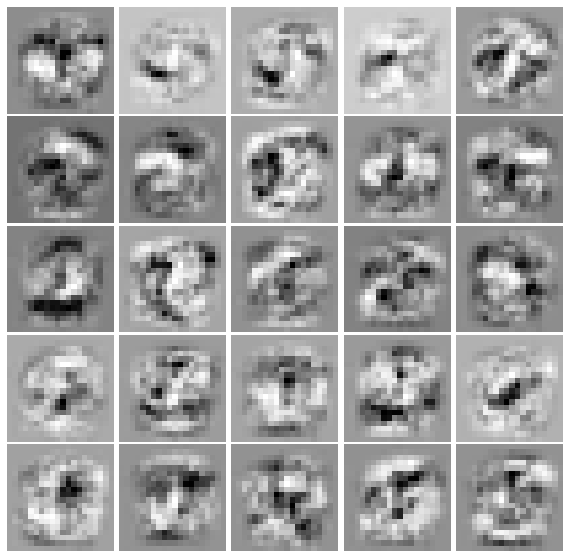

In [13]:
utils.displayData(Theta1.T)

# Overfitting evaluation

In [14]:
class Net(nn.Module):
    def __init__(self, epochs=100, batch_size=10):
        super().__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.epochs = epochs
        self.batch_size = batch_size
        self.train_loss = []
        self.val_loss = []
        self.train_loader = None
        self.val_loader = None
        self.lrs = None

        
    def create_dataloader(self, X, y=None, val_size=0.2, shuffle=True):
        X = torch.tensor(X, dtype=torch.float32)
        data = (X, torch.tensor(y, dtype=torch.long)) if y is not None else (X,)
        data = torch.utils.data.TensorDataset(*data)        
        
        if val_size > 0:
            val_length = int(data.tensors[0].shape[0] * val_size)
            train_length = data.tensors[0].shape[0] - val_length
            data_train, data_val = torch.utils.data.random_split(data, [train_length, val_length])
            return torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=shuffle), \
                    torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=shuffle)
        
        else:
            return torch.utils.data.DataLoader(data, batch_size=self.batch_size, shuffle=shuffle)
        
    def fit(self, X, y, val_size=0.2, shuffle=True):
        # create dataloaders as tensor datasets
        self.train_loader, self.val_loader = self.create_dataloader(X, y, val_size, shuffle)

        # initialize weights
        self.apply(self._initialize_weights)

        for epoch in range(epochs):
            self.train()
            prefix = f'Epoch {epoch + 1}/{epochs}'
            loss_train = list()

            epoch_outputs, epoch_targets = torch.Tensor(), torch.Tensor().new_empty(0, dtype=torch.long)
            pbar = tqdm(enumerate(self.train_loader), desc=prefix, mininterval=0.5)
            for idx, (inputs, targets) in pbar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # ===================forward=====================
                output = self.to(self.device)(inputs)
                loss = self.criterion(output, targets)
                # ===================backward====================
                loss.backward()

                # update optimizer
                self.optimizer.step()
                self.optimizer.zero_grad()

                # ====================metrics====================
                loss_train.append(loss.item())

                # overall running metric computation
                epoch_outputs = torch.cat([epoch_outputs, output], dim=0)
                epoch_targets = torch.cat([epoch_targets, targets], dim=0)

                # ===================log========================
                if idx % 50 == 0:
                    acc = self._evaluate(epoch_outputs, epoch_targets)
                    suffix = f'| Training loss: {np.mean(loss_train):.4g}'
                    suffix += f' | Accuracy: {acc:.3g}'
                    pbar.set_postfix_str(suffix)
            else:
                # save epoch training loss
                self.train_loss.append(np.mean(loss_train))

            # ===================Evaluation======================
            if self.val_loader is not None:
                self.eval()
                loss_val = list()

                epoch_val_outputs, epoch_val_targets = torch.Tensor(), torch.Tensor().new_empty(0, dtype=torch.long)
                for idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    output = self.to(self.device)(inputs)
                    loss_val.append(self.criterion(output, targets).item())

                    # overall running metric computation
                    epoch_val_outputs = torch.cat([epoch_val_outputs, output], dim=0)
                    epoch_val_targets = torch.cat([epoch_val_targets, targets], dim=0)

                else:
                    self.val_loss.append(np.mean(loss_val))

#                 # ===================log========================
#                 acc = self._evaluate(epoch_val_outputs, epoch_val_targets)
#                 suffix += f' | Val loss: {np.mean(loss_train):.4g}'
#                 suffix += f' | Val Accuracy: {acc:.3g}'
#                 pbar.clear()
#                 pbar.refresh(nolock=True)
#                 print(f'{prefix}: {suffix[1:]}')

    def evaluate(self, X, y):
        outputs = self.predict(X)
        return self._evaluate(outputs, torch.tensor(y, dtype=torch.long))

    def _evaluate(self, outputs, targets):
        # calculate metrics here
        outputs = torch.max(outputs, dim=1)[1]
        return np.mean((outputs == targets).numpy())

    def predict(self, X):
        self.eval()
        loader = self.create_dataloader(X)

        outputs = torch.Tensor()
        for inputs in tqdm(loader, desc='Predicting'):
            inputs = inputs[0].to(self.device)
            output = self.to(self.device)(inputs)
            outputs = torch.cat([outputs, output], 0)

        return outputs

    @staticmethod
    def _initialize_weights(mod):
        if hasattr(mod, 'weight') and (not isinstance(mod, torch.nn.modules.loss._Loss)):
            nn.init.xavier_uniform_(mod.weight)

In [15]:
class NN(Net):

    def __init__(self, input_size, hidden_size, output_size, criterion, optimizer,
                 learning_rate=0.001, epochs=100, batch_size=10, weight_decay=0.001):
        super().__init__(epochs, batch_size)

        self.linear1 = nn.Linear(input_size, hidden_size, bias=True)
        self.linear2 = nn.Linear(hidden_size, output_size, bias=True)

        self.criterion = criterion
        self.optimizer = optimizer(self.parameters(), lr=learning_rate, weight_decay=weight_decay)


    def forward(self, x):
        hidden_layer = torch.sigmoid(self.linear1(x))
        return self.linear2(hidden_layer)


    def predict_classes(self, X):
        outputs = self.predict(X)
        return torch.max(outputs, dim=1)[1]

In [16]:
model = NN(input_size, hidden_size, num_labels, cost_function, optimizer, lr, epochs, batch_size, lambda_)

In [17]:
model.fit(X, y)

Epoch 1/100: 400it [00:00, 479.00it/s, | Training loss: 1.988 | Accuracy: 0.512]
Epoch 2/100: 400it [00:00, 460.01it/s, | Training loss: 1.457 | Accuracy: 0.784]
Epoch 3/100: 400it [00:00, 470.81it/s, | Training loss: 1.131 | Accuracy: 0.826]
Epoch 4/100: 400it [00:00, 452.71it/s, | Training loss: 0.9227 | Accuracy: 0.849]
Epoch 5/100: 400it [00:00, 465.07it/s, | Training loss: 0.7737 | Accuracy: 0.865]
Epoch 6/100: 400it [00:00, 458.71it/s, | Training loss: 0.6765 | Accuracy: 0.873]
Epoch 7/100: 400it [00:00, 402.82it/s, | Training loss: 0.6037 | Accuracy: 0.884]
Epoch 8/100: 400it [00:01, 399.17it/s, | Training loss: 0.5424 | Accuracy: 0.891]
Epoch 9/100: 400it [00:00, 440.51it/s, | Training loss: 0.5031 | Accuracy: 0.897]
Epoch 10/100: 400it [00:01, 356.79it/s, | Training loss: 0.466 | Accuracy: 0.903] 
Epoch 11/100: 400it [00:01, 389.61it/s, | Training loss: 0.4405 | Accuracy: 0.905]
Epoch 12/100: 400it [00:00, 437.16it/s, | Training loss: 0.4205 | Accuracy: 0.908]
Epoch 13/100: 40

Epoch 99/100: 400it [00:00, 522.19it/s, | Training loss: 0.2059 | Accuracy: 0.953]
Epoch 100/100: 400it [00:00, 499.66it/s, | Training loss: 0.2066 | Accuracy: 0.954]


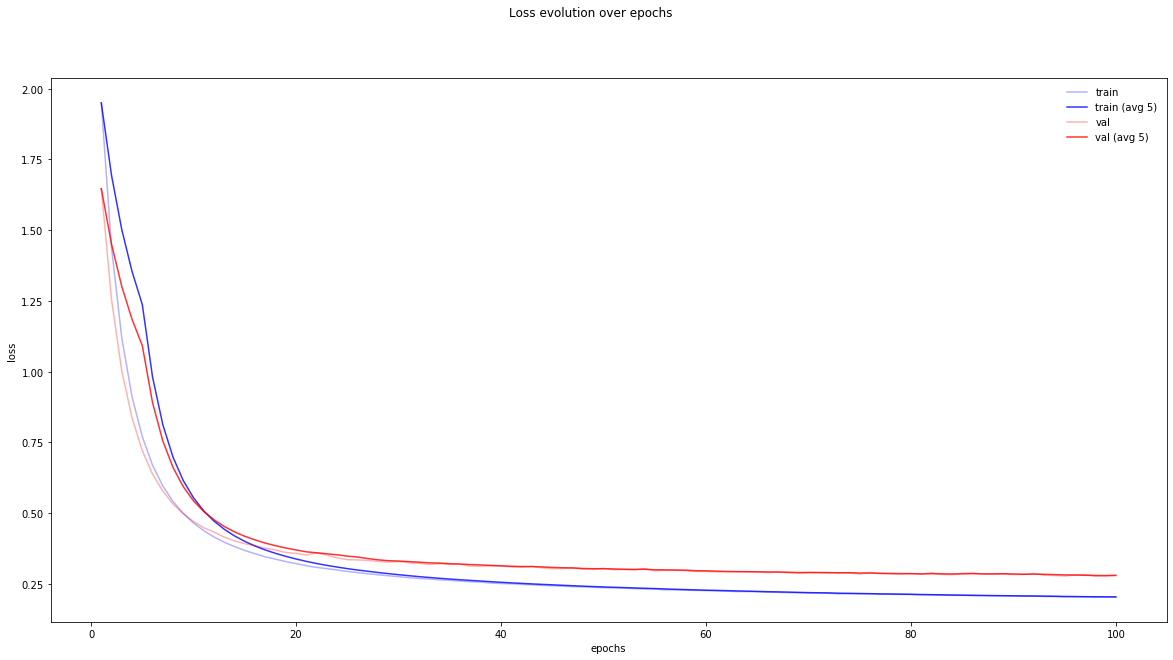

In [19]:
utils.plot_loss(model.train_loss, model.val_loss, ma_n_periods=5)